In [1]:
import numpy as np
import pickle
from astropy.io import fits
import matplotlib
#matplotlib.use('agg')
import matplotlib.pyplot as plt
from galpy.util import bovy_conversion, bovy_coords, save_pickles, bovy_plot
from galpy.potential import MWPotential2014, turn_physical_off, vcirc
import astropy.units as u
from galpy.orbit import Orbit
from scipy import integrate, interpolate
from scipy.integrate import quad
import scipy.optimize as optimize
from optparse import OptionParser
import GMC_GC_util
import gd1_util
import pal5_util_MWfit
import MWPotential2014Likelihood
import numpy

ro=8.
vo=220.

In [2]:
#Load the stream objects

timescdm = '3.2'
arm = 'leading'
sigv='0p3'
td=3.2


with open('pkl_files/pklfiles_{}Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(td,arm,td),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')

In [6]:
def dndM_cdm(M,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #c0kpc=2.02*10**(-13) #Msun^-1 kpc^-3 from Denis' paper
    m0=2.52*10**7 #Msun from Denis' paper
    return c0kpc*((M/m0)**mf_slope)

def Einasto(r):
    al=0.678 #alpha_shape
    rm2=199 #kpc, see Erkal et al 1606.04946 for scaling to M^1/3
    return numpy.exp((-2./al)*((r/rm2)**al -1.))*4*numpy.pi*(r**2)

def nsub_cdm(M1,M2,r=20.,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #number density of subhalos in kpc^-3
    m1=10**(M1)
    m2=10**(M2)
    return integrate.quad(dndM_cdm,m1,m2,args=(c0kpc,mf_slope))[0]*integrate.quad(Einasto,0.,r)[0]*(8.**3.)/(4*numpy.pi*(r**3)/3) #in Galpy units

def rs(m,plummer=True,rsfac=1.):
    if plummer:
        #print ('Plummer')
        return 1.62*rsfac/ro*(m/10.**8.)**0.5
    else:
        return 1.05*rsfac/ro*(m/10.**8.)**0.5
    


def simulate_subhalos(rand_params,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.):
    
    Mbin_edge=[5.,6.,7.,8.,9.]
    Nbins=len(Mbin_edge)-1
    #compute number of subhalos in each mass bin and multiply rand_params
    nden_bin=np.empty(Nbins)
    rate_bin=np.empty(Nbins)
    for ll in range(Nbins):
        nden_bin[ll]=nsub_cdm(Mbin_edge[ll],Mbin_edge[ll+1])*rand_params[ll] #fiducial CDM
        Mmid=10**(0.5*(Mbin_edge[ll]+Mbin_edge[ll+1]))
        rate_bin[ll]=sdf_pepper.subhalo_encounters(sigma=sigma,nsubhalo=nden_bin[ll],bmax=Xrs*rs(Mmid,plummer=True))

    rate = np.sum(rate_bin)
    rel_rate=rate_bin/rate
    rel_rate=list(rel_rate)
        
    Nimpact= numpy.random.poisson(rate)
    impact_ind_bin=np.random.choice(Nbins,Nimpact,p=rel_rate) #index of mass bin where the impact was sampled
    nimpact_bin=np.histogram(impact_ind_bin,bins=np.arange(len(Mbin_edge)))[0]
    
    GM_sub=[]
    impact_angle_sub=[]
    timpact_sub=[]
    
    for ii in range(Nbins):
        norm= 1./quad(lambda M : ((M)**(mf_slope +0.5)),10**(Mbin_edge[ii]),10**(Mbin_edge[ii+1]))[0]
        
        def cdf(M):
            return quad(lambda M : norm*(M)**(mf_slope +0.5),10**Mbin_edge[ii],M)[0]

        MM=numpy.linspace(Mbin_edge[ii],Mbin_edge[ii+1],10000)
        
        cdfl=[cdf(i) for i in 10**MM]
        
        icdf= interpolate.InterpolatedUnivariateSpline(cdfl,10**MM,k=1)
        timpacts= numpy.array(sdf_pepper._uniq_timpact)[numpy.random.choice(len(sdf_pepper._uniq_timpact),size=nimpact_bin[ii],
                                    p=sdf_pepper._ptimpact)]
        # Sample angles from the part of the stream that existed then
        impact_angles= numpy.array([sdf_pepper._icdf_stream_len[ti](numpy.random.uniform())
                for ti in timpacts])
        sample_GM=lambda: icdf(numpy.random.uniform())/bovy_conversion.mass_in_msol(vo,ro)
        GMs= numpy.array([sample_GM() for a in impact_angles])
        
        GM_sub+=list(GMs)
        impact_angle_sub+=list(impact_angles)
        timpact_sub+=list(timpacts)
    
    GM_sub=np.array(GM_sub)
    impact_angle_sub=np.array(impact_angle_sub)
    timpact_sub=np.array(timpact_sub)
    
    rs_sub= numpy.array([rs(gm) for gm in GM_sub])
    # impact b
    impactb_sub= (2.*numpy.random.uniform(size=len(impact_angle_sub))-1.)*Xrs*rs_sub
    # velocity
    subhalovel_sub= numpy.empty((len(impact_angle_sub),3))
    for jj in range(len(timpact_sub)):
        subhalovel_sub[jj]=sdf_pepper._draw_impact_velocities(timpact_sub[jj],sigma,impact_angle_sub[jj],n=1)[0]
    # Flip angle sign if necessary
    #if not sdf_pepper._gap_leading: impact_angles*= -1.
    #angles not flipped, flip them after including angles from GMC and GC impacts     
    return impact_angle_sub,impactb_sub,subhalovel_sub,timpact_sub,GM_sub,rs_sub     


In [ ]:
#draw random parameters from uniform distributions that will multiply number desntiy of subhalos per mass bin
param_min=-1. #sample in log_10
param_max=1.
rand_params=numpy.random.uniform(size=4)*(param_max-param_min)+param_min

rand_params=10**(rand_params)
print (rand_params)


rand_params_fid=np.ones(4)

Msub_fid=[]
Msub=[]

for jj in range(500):
    _,_,_,_,GMsf,_ =simulate_subhalos(rand_params_fid,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.)
    for m in GMsf:
        Msub_fid.append(m*bovy_conversion.mass_in_msol(vo,ro))
        
    _,_,_,_,GMs,_ =simulate_subhalos(rand_params,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.)
    for mm in GMs:
        Msub.append(mm*bovy_conversion.mass_in_msol(vo,ro))

Mbins=10**(np.array([5.,6.,7.,8.,9.]))  

count=np.histogram(Msub,bins=Mbins)[0]/np.histogram(Msub_fid,bins=Mbins)[0]
cc=np.insert(count,-1,count[-1])

plt.figure()
#plt.hist(Msub_fid,bins=Mbins,color='r',histtype='step',label='Fid CDM')
#plt.hist(Msub,bins=Mbins,color='b',histtype='step')
plt.step(Mbins,cc,where='post')
plt.hlines(rand_params[0],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[1],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[2],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[3],10**5.,10**9.,color='r',linestyle='--')
plt.xscale('log')
#plt.legend(loc='upper right')
plt.show()
        

In [ ]:
#draw random parameters from uniform distributions that will multiply number desntiy of subhalos per mass bin
param_min=-1. #sample in log_10
param_max=1.
rand_params=numpy.random.uniform(size=4)*(param_max-param_min)+param_min

rand_params=10**(rand_params)
print (rand_params)


rand_params_fid=np.ones(4)

Msub_fid=[]
Msub=[]

for jj in range(500):
    _,_,_,_,GMsf,_ =simulate_subhalos(rand_params_fid,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.)
    for m in GMsf:
        Msub_fid.append(m*bovy_conversion.mass_in_msol(vo,ro))
        
    _,_,_,_,GMs,_ =simulate_subhalos(rand_params,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.)
    for mm in GMs:
        Msub.append(mm*bovy_conversion.mass_in_msol(vo,ro))

Mbins=10**(np.array([5.,6.,7.,8.,9.]))  

count=np.histogram(Msub,bins=Mbins)[0]/np.histogram(Msub_fid,bins=Mbins)[0]
cc=np.insert(count,-1,count[-1])

plt.figure()
#plt.hist(Msub_fid,bins=Mbins,color='r',histtype='step',label='Fid CDM')
#plt.hist(Msub,bins=Mbins,color='b',histtype='step')
plt.step(Mbins,cc,where='post')
plt.hlines(rand_params[0],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[1],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[2],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[3],10**5.,10**9.,color='r',linestyle='--')
plt.xscale('log')
#plt.legend(loc='upper right')
plt.show()
        

In [ ]:
#draw random parameters from uniform distributions that will multiply number desntiy of subhalos per mass bin
param_min=-1. #sample in log_10
param_max=1.
rand_params=numpy.random.uniform(size=4)*(param_max-param_min)+param_min

rand_params=10**(rand_params)
print (rand_params)


rand_params_fid=np.ones(4)

Msub_fid=[]
Msub=[]

for jj in range(500):
    _,_,_,_,GMsf,_ =simulate_subhalos(rand_params_fid,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.)
    for m in GMsf:
        Msub_fid.append(m*bovy_conversion.mass_in_msol(vo,ro))
        
    _,_,_,_,GMs,_ =simulate_subhalos(rand_params,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.)
    for mm in GMs:
        Msub.append(mm*bovy_conversion.mass_in_msol(vo,ro))

Mbins=10**(np.array([5.,6.,7.,8.,9.]))  

count=np.histogram(Msub,bins=Mbins)[0]/np.histogram(Msub_fid,bins=Mbins)[0]
cc=np.insert(count,-1,count[-1])

plt.figure()
#plt.hist(Msub_fid,bins=Mbins,color='r',histtype='step',label='Fid CDM')
#plt.hist(Msub,bins=Mbins,color='b',histtype='step')
plt.step(Mbins,cc,where='post')
plt.hlines(rand_params[0],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[1],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[2],10**5.,10**9.,color='r',linestyle='--')
plt.hlines(rand_params[3],10**5.,10**9.,color='r',linestyle='--')
plt.xscale('log')
#plt.legend(loc='upper right')
plt.show()
        

In [ ]:
def dndM_cdm(M,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #c0kpc=2.02*10**(-13) #Msun^-1 kpc^-3 from Denis' paper
    m0=2.52*10**7 #Msun from Denis' paper
    return c0kpc*((M/m0)**mf_slope)

def Einasto(r):
    al=0.678 #alpha_shape
    rm2=199 #kpc, see Erkal et al 1606.04946 for scaling to M^1/3
    return numpy.exp((-2./al)*((r/rm2)**al -1.))*4*numpy.pi*(r**2)

def nsub_cdm(M1,M2,r=20.,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #number density of subhalos in kpc^-3
    m1=10**(M1)
    m2=10**(M2)
    return integrate.quad(dndM_cdm,m1,m2,args=(c0kpc,mf_slope))[0]*integrate.quad(Einasto,0.,r)[0]*(8.**3.)/(4*numpy.pi*(r**3)/3) #in Galpy units




In [10]:
def best_fit_alpha(rand_fac=[1.,1.,1.,1.]):
    #np.sum(np.array(diff)**2/  (rand_fac[ii]*nsub_cdm(MM[ii],MM[ii+1]))  )
    MM=[5.,6.,7.,8.,9.]
    rand_fid_nsub = [rand_fac[ii]*nsub_cdm(MM[ii],MM[ii+1]) for ii in range(len(rand_fac))]
    
    def diff_func(params,rand_fac=rand_fac,rand_fid_nsub=rand_fid_nsub):
        
        c0,slope=params
        c0*=2.02*10**(-13)
        slope*=-1.9
        diff = [nsub_cdm(MM[ii],MM[ii+1],c0kpc=c0,mf_slope=slope) - rand_fid_nsub[ii] for ii in range(len(rand_fac))]
        #print (diff)
        return np.sum((np.array(diff)**2) /np.array(rand_fid_nsub))
    
    result = optimize.minimize(diff_func, x0=[1.,1.],args=(rand_fac),method='nelder-mead')
    return result.x

print (best_fit_alpha(rand_fac=[1.,1.,1.,1.]))

[1. 1.]


random parameters are [0.56548436 9.32846695 6.13093809 1.40264423]
3.4921464858754776 0.813176035479205
best fit norm = 7.054135901468465e-13 and best fit slope = -1.5450344674104894


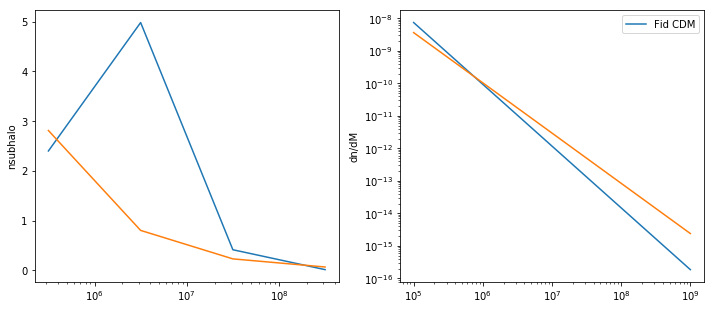

random parameters are [0.85232387 2.83277157 0.87504418 0.25442147]
1.4045836784160675 0.9507425038339632
best fit norm = 2.8372590304004566e-13 and best fit slope = -1.80641075728453


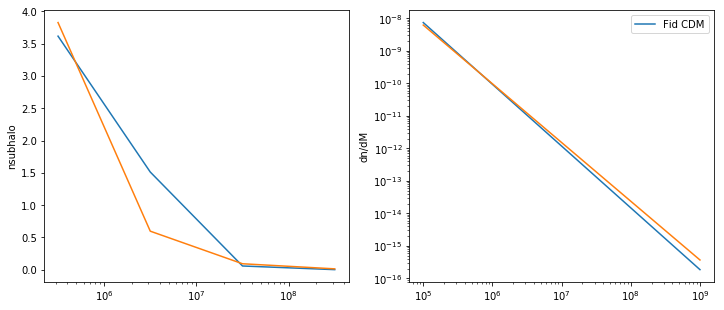

random parameters are [0.34306335 4.87953258 0.22004331 1.85350751]
0.7942396193328605 0.9149853512536987
best fit norm = 1.6043640310523782e-13 and best fit slope = -1.7384721673820276


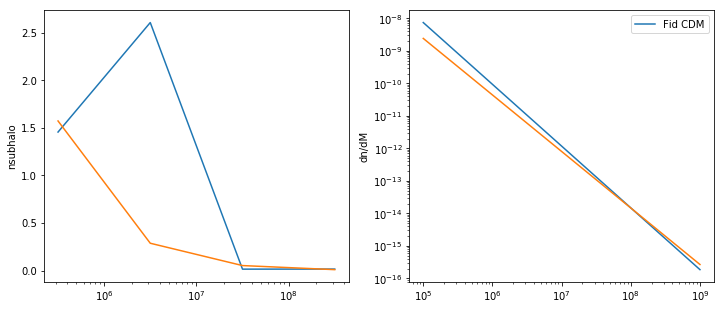

random parameters are [0.35961426 3.24140498 3.60129122 0.72381991]
1.9287687944905627 0.8263680981139307
best fit norm = 3.896112964870937e-13 and best fit slope = -1.5700993864164683


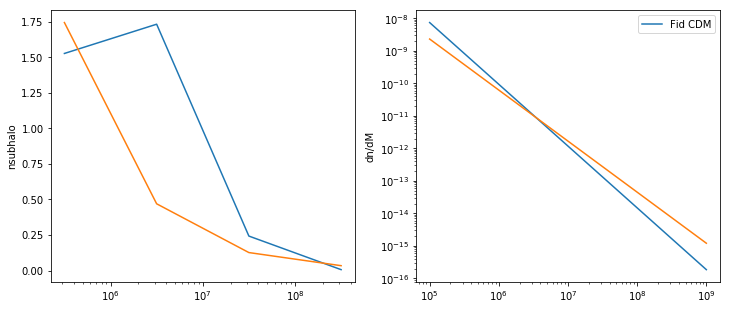

random parameters are [0.7527321  4.32361089 1.01362102 0.1870361 ]
1.3649445518249066 0.9422390980504047
best fit norm = 2.7571879946863114e-13 and best fit slope = -1.7902542862957689


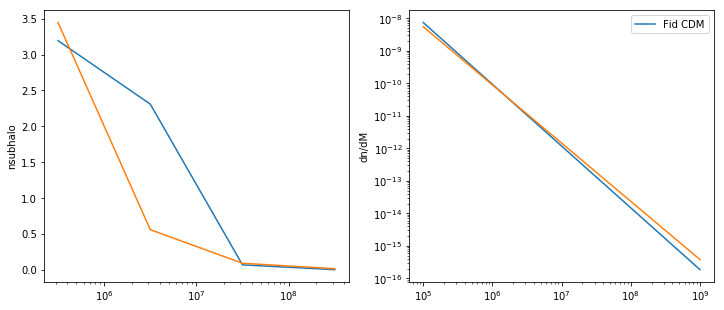

random parameters are [6.51044456 7.87305039 0.16635358 4.76550817]
1.0957752743631204 1.1966839750060114
best fit norm = 2.2134660542135033e-13 and best fit slope = -2.2736995525114216


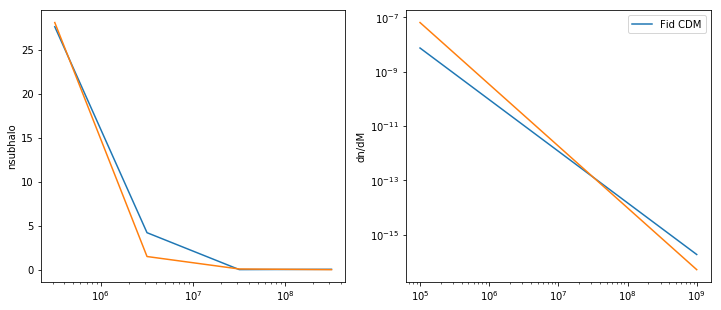

random parameters are [0.10666777 0.81204771 6.48764129 1.3067282 ]
1.3570310298468167 0.7309251456574187
best fit norm = 2.7412026802905697e-13 and best fit slope = -1.3887577767490955


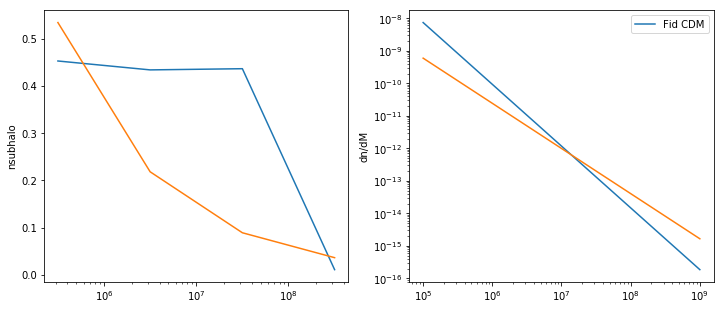

random parameters are [0.74909702 0.55189538 3.31825409 8.28681564]
0.614382006635311 1.0204175803192361
best fit norm = 1.2410516534033284e-13 and best fit slope = -1.9387934026065485


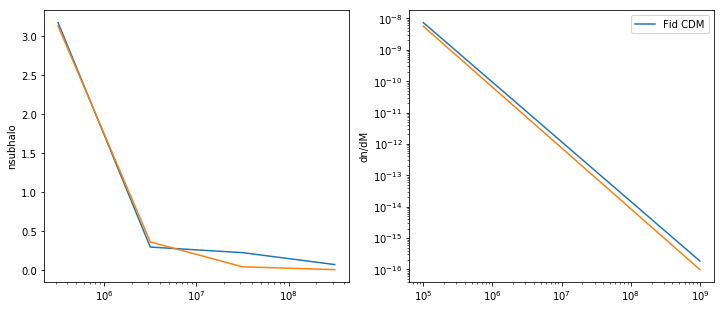

random parameters are [2.26012075 2.89963513 0.20876571 3.24118004]
0.865599056031156 1.1076847880465204
best fit norm = 1.748510093182935e-13 and best fit slope = -2.1046010972883886


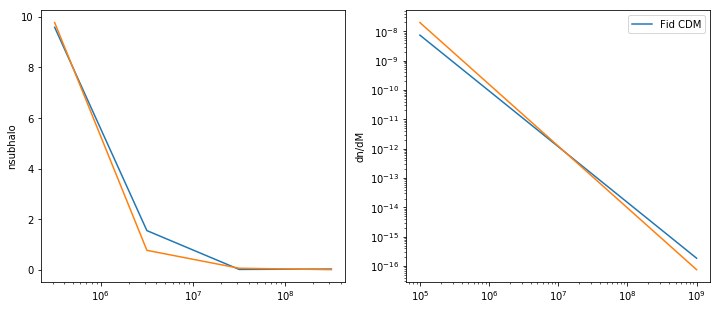

random parameters are [0.36754069 0.23690228 0.27530042 1.68644765]
0.17506456557144215 1.0812775289308658
best fit norm = 3.5363042245431315e-14 and best fit slope = -2.054427304968645


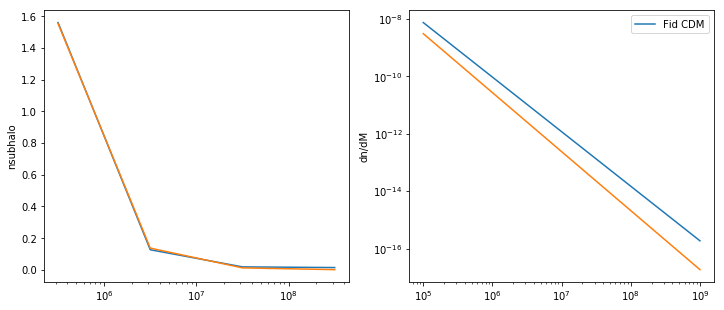

In [11]:
param_min=-1. #sample in log_10
param_max=1.

for ll in range(10):
    rand_params=numpy.random.uniform(size=4)*(param_max-param_min)+param_min

    rand_params=10**(rand_params)
    print ("random parameters are",rand_params)

    norm,alpha = best_fit_alpha(rand_fac=list(rand_params))
    print (norm,alpha)
    print ("best fit norm = {} and best fit slope = {}".format(norm*2.02*10**(-13),-1.9*alpha))

    MM=[5.,6.,7.,8.,9.]
    nbins = [rand_params[ii]*nsub_cdm(MM[ii],MM[ii+1]) for ii in range(len(rand_params))]
    Mmid= [10**(0.5*(MM[i] + MM[i+1])) for i in range(len(MM)-1)]

    mm=10**(np.linspace(5.,9.,100))

    nbin_fit = [nsub_cdm(MM[j],MM[j+1],r=20.,c0kpc=norm*2.02*10**(-13),mf_slope=-1.9*alpha) for j in range(len(MM)-1)]

    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(Mmid,nbins)
    plt.plot(Mmid,nbin_fit)
    plt.ylabel(r'nsubhalo')
    plt.xscale('log')

    plt.subplot(1,2,2)
    plt.plot(mm,dndM_cdm(mm),label='Fid CDM')
    plt.plot(mm,dndM_cdm(mm,c0kpc=norm*2.02*10**(-13),mf_slope=-1.9*alpha))
    plt.ylabel(r'dn/dM')
    plt.xscale('log')
    plt.yscale('log')
    plt.legend(loc='upper right')
    plt.show()


In [ ]:
param_min=-1. #sample in log_10
param_max=1.

fo=open('random_params_vary_MF.dat','w')
fo.write('#rand1   rand2   rand3  rand4  slope  norm' + '\n')

for ll in range(10000):
    rand_params=numpy.random.uniform(size=4)*(param_max-param_min)+param_min
    rand_params=10**(rand_params)
    #print ("random parameters are",rand_params)
    norm,alpha = best_fit_alpha(rand_fac=list(rand_params))
    norm=norm*2.02*10**(-13)
    alpha = -1.9*alpha
    fo.write(str(rand_params[0])+"   "+str(rand_params[1])+"   "+str(rand_params[2])+"   "+str(rand_params[3])+"   "+str(alpha)+"   "+str(norm) + '\n') 
    
fo.close()

In [ ]:
rand_dat_all=np.loadtxt('random_params_vary_MF.dat')

#print (rand_dat[0:30])

batch = 0
ind_min=0
ind_max=50
batchsize=ind_max-ind_min
rand_params=rand_dat_all[batch*batchsize:(batch+1)*batchsize]

print (rand_params[0][:4])
print (rand_params[0][0])


impact_angle_sub,impactb_sub,subhalovel_sub,timpact_sub,GM_sub,rs_sub=simulate_subhalos(rand_params[0][:4],sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.)

print (len(rs_sub))



In [ ]:
def nsub_cdm(M1,M2,r=20.,c0kpc=2.02*10**(-13),mf_slope=-1.9):
    #number density of subhalos in kpc^-3
    m1=10**(M1)
    m2=10**(M2)
    return integrate.quad(dndM_cdm,m1,m2,args=(c0kpc,mf_slope))[0]*integrate.quad(Einasto,0.,r)[0]*(8.**3.)/(4*numpy.pi*(r**3)/3) #in Galpy units



def simulate_subhalos(rand_params,sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.,sigma=120./220.):
    
    Mbin_edge=[5.,6.,7.,8.,9.]
    Nbins=len(Mbin_edge)-1
    #compute number of subhalos in each mass bin and multiply rand_params
    nden_bin=np.empty(Nbins)
    rate_bin=np.empty(Nbins)
    for ll in range(Nbins):
        nden_bin[ll]=nsub_cdm(Mbin_edge[ll],Mbin_edge[ll+1])*rand_params[ll] #fiducial CDM
        Mmid=10**(0.5*(Mbin_edge[ll]+Mbin_edge[ll+1]))
        rate_bin[ll]=sdf_pepper.subhalo_encounters(sigma=sigma,nsubhalo=nden_bin[ll],bmax=Xrs*rs(Mmid,plummer=True))

    rate = np.sum(rate_bin)
    rel_rate=rate_bin/rate
    rel_rate=list(rel_rate)
    
    print (rate)
        
    Nimpact= numpy.random.poisson(rate)
    impact_ind_bin=np.random.choice(Nbins,Nimpact,p=rel_rate) #index of mass bin where the impact was sampled
    nimpact_bin=np.histogram(impact_ind_bin,bins=np.arange(len(Mbin_edge)))[0]
    print (nimpact_bin)
    GM_sub=[]
    impact_angle_sub=[]
    timpact_sub=[]
    
    for ii in range(Nbins):
        norm= 1./quad(lambda M : ((M)**(mf_slope +0.5)),10**(Mbin_edge[ii]),10**(Mbin_edge[ii+1]))[0]
        
        def cdf(M):
            return quad(lambda M : norm*(M)**(mf_slope +0.5),10**Mbin_edge[ii],M)[0]

        MM=numpy.linspace(Mbin_edge[ii],Mbin_edge[ii+1],10000)
        
        cdfl=[cdf(i) for i in 10**MM]
        
        icdf= interpolate.InterpolatedUnivariateSpline(cdfl,10**MM,k=1)
        timpacts= numpy.array(sdf_pepper._uniq_timpact)[numpy.random.choice(len(sdf_pepper._uniq_timpact),size=nimpact_bin[ii],
                                    p=sdf_pepper._ptimpact)]
        # Sample angles from the part of the stream that existed then
        impact_angles= numpy.array([sdf_pepper._icdf_stream_len[ti](numpy.random.uniform())
                for ti in timpacts])
        sample_GM=lambda: icdf(numpy.random.uniform())/bovy_conversion.mass_in_msol(vo,ro)
        GMs= numpy.array([sample_GM() for a in impact_angles])
        
        GM_sub+=list(GMs)
        impact_angle_sub+=list(impact_angles)
        timpact_sub+=list(timpacts)
        print (timpacts)
    
    GM_sub=np.array(GM_sub)
    impact_angle_sub=np.array(impact_angle_sub)
    timpact_sub=np.array(timpact_sub)
    
    rs_sub= numpy.array([rs(gm*bovy_conversion.mass_in_msol(vo,ro)) for gm in GM_sub])
    # impact b
    impactb_sub= (2.*numpy.random.uniform(size=len(impact_angle_sub))-1.)*Xrs*rs_sub
    # velocity
    subhalovel_sub= numpy.empty((len(impact_angle_sub),3))
    for jj in range(len(timpact_sub)):
        subhalovel_sub[jj]=sdf_pepper._draw_impact_velocities(timpact_sub[jj],sigma,impact_angle_sub[jj],n=1)[0]
    # Flip angle sign if necessary
    #if not sdf_pepper._gap_leading: impact_angles*= -1.
    #angles not flipped, flip them after including angles from GMC and GC impacts     
    return impact_angle_sub,impactb_sub,subhalovel_sub,timpact_sub,GM_sub,rs_sub 


rand_dat_all=np.loadtxt('random_params_vary_MF.dat')
#batchsize=options.ind_max - options.ind_min
rand_params=rand_dat_all[:5] #[[options.batch*batchsize:(options.batch+1)*batchsize]


     

for ii in range(len(rand_params)):
            
    with open('pkl_files/pklfiles_3.2Gyr_sigv0.3/gd1_smooth_pepper_leading_Plummer_sigv0.3_td3.2_64sampling_progphi1-40.0_MW2014.pkl','rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')
    
    impact_angles=[]
    impactbs=[]
    subhalovels=[]
    timpacts=[]
    GMs=[]
    rss=[]                                                
    print (rand_params[ii])                                                                                                  
    impact_angle_sub,impactb_sub,subhalovel_sub,timpact_sub,GM_sub,rs_sub =simulate_subhalos(rand_params[ii][:4],sdf_pepper,mf_slope=-1.9,c0kpc=2.02*10**(-13),Xrs=5.)
    
    print (GM_sub*bovy_conversion.mass_in_1010msol(vo,ro)*10.**10.)
    print (GM_sub*bovy_conversion.mass_in_msol(vo,ro))

    
    
    impact_angles+=list(impact_angle_sub)
    impactbs+=list(impactb_sub)
    subhalovels+=list(subhalovel_sub)
    timpacts+=list(timpact_sub)
    GMs+=list(GM_sub)
    rss+=list(rs_sub)
    
    
    # Flip angle sign if necessary
    if not sdf_pepper._gap_leading: impact_angles*= -1.     
    
    sdf_pepper.set_impacts(impactb=impactbs,subhalovel=subhalovels,impact_angle=impact_angles,timpact=timpacts,rs=rss,GM=GMs)
       
    apar_out=np.arange(0.01,1.,0.01)
        
    dens_unp= [sdf_smooth._density_par(a) for a in apar_out]
    omega_unp= [sdf_smooth.meanOmega(a,oned=True) for a in apar_out]
    densOmega= np.array([sdf_pepper._densityAndOmega_par_approx(a) for a in apar_out]).T
    
    
    fo=open('GD1_prog-40_sigv-40_leading_densOmega_subhalo_Plummer_rand_rotate_{}.dat'.format(ii),'w')
    
                                                                                                             
    fo.write('#apar   dens_unp   dens  omega_unp   omega' + '\n')
    
    for  jj in range(len(apar_out)):
        fo.write(str(rand_params[ii][0])+'    '+str(rand_params[ii][1])+'    '+str(rand_params[ii][2])+'    '+str(rand_params[ii][3]) + '    ' + str(apar_out[jj]) + '   ' + str(dens_unp[jj]) + '   ' + str(densOmega[0][jj]) + '   ' + str(omega_unp[jj]) + '   ' + str(densOmega[1][jj]) + '\n' )
            
    fo.close()

In [ ]:
from gd1_util_MWhaloshape import lb_to_phi12
from scipy.optimize import brentq

def compute_obs_density(phi1,apars,dens_apar,Omega):
    
    apar_edge=[]
    phi1_edge=[]

    abw0=apars[1]-apars[0]
    apar_edge.append(apars[0]-(abw0/2.))

    phi1bw0=phi1[1]-phi1[0]
    phi1_edge.append(phi1[0]-(phi1bw0/2.))

    for ii in range(len(apars)-1):
        abw=apars[ii+1]-apars[ii]
        phi1bw=phi1[ii+1]-phi1[ii]
        apar_edge.append(apars[ii]+abw/2.)
        phi1_edge.append(phi1[ii]+phi1bw/2.)


    abw_last=apars[len(apars)-1]-apars[len(apars)-2]
    apar_edge.append(apars[len(apars)-1]+(abw_last/2.))

    phi1bw_last=phi1[len(phi1)-1]-phi1[len(phi1)-2]
    phi1_edge.append(phi1[len(phi1)-1]+(phi1bw_last/2.))

    #compute the Jacobian d(apar)/d(phi1) using finite difference method
    dapar_dphi1=np.fabs(numpy.diff(apar_edge)/numpy.diff(phi1_edge))
    #print (dapar_dphi1)
   
    #Interpolate dens(apar)
    ipdens_apar= interpolate.InterpolatedUnivariateSpline(apars,dens_apar)

    #Interpolate apar(phi1)
    if phi1[1] < phi1[0] : # ad-hoc way of checking whether increasing or decreasing
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1[::-1],apars[::-1])
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dapar_dphi1[::-1])
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],ipdens_apar(ipphi1(phi1[::-1]))*ipdapar_dphi1(phi1[::-1]))
        
    else :
        ipphi1= interpolate.InterpolatedUnivariateSpline(phi1,apars)
        #Interpolate Jacobian
        ipdapar_dphi1=interpolate.InterpolatedUnivariateSpline(phi1,dapar_dphi1)
        #Interpolate density(phi1) by multiplying by jacobian
        dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,ipdens_apar(ipphi1(phi1))*ipdapar_dphi1(phi1))
            
    
    
    return (dens_phi1(phi1))


def compute_length(phi1,dens_phi1,arm='trailing',threshold=0.2):
    
    
    if phi1[1] < phi1[0]:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])
        
    else:
        ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)
    
    if arm == 'leading' :     
        mean_den=np.mean(dens_phi1[(phi1 >= -44.) & (phi1 <= -40.)])
        try:
            length=np.abs(-40. - brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,-88.,-40.))
            
        except ValueError:
            #length = -40.-(-60.) # full length
            length = -40.-(-88.) # full length
            
    else :    
        mean_den=np.mean(dens_phi1[(phi1 >= -40.) & (phi1 <= -36.)])
        try:
            #length=np.abs(min(phi1)-brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,min(phi1),-4.))
            length=np.abs(min(phi1)-brentq(lambda x: ip_dens_phi1(x)-mean_den*threshold,-40.,10.))
            #print (length)
        except ValueError as e:
            #print (e)
            #print (dens_phi1)
            #length = -4.-(-40.) # full length
            length = 10.-(-40.) # full length
            
    return (length)


dir='dens_Omega/sims_for_ABC_varyMF/'

jj='GD1_prog-40_sigv-40_leading_densOmega_subhalo_Plummer_rand_rotate_1.dat'


dat=np.loadtxt(jj)
apars=dat[:,4]
dens_smooth=dat[:,5]
dens=dat[:,6]
Omega=dat[:,8]

plt.figure()
#plt.plot(apars,Omega)
plt.plot(apars,dens/dens_smooth)
plt.show()

#Load the stream objects

timescdm = '3.2'
arm = 'leading'
sigv='0p3'
td=3.2

with open('pkl_files/pklfiles_{}Gyr_sigv0.3/gd1_smooth_pepper_{}_Plummer_sigv0.3_td{}_64sampling_progphi1-40.0_MW2014.pkl'.format(td,arm,td),'rb') as savefile:
            sdf_smooth= pickle.load(savefile,encoding='latin1')
            sdf_pepper= pickle.load(savefile,encoding='latin1')
        
mT= sdf_pepper.meanTrack(apars,_mO=Omega,coord='lb')
phi1=lb_to_phi12(mT[0],mT[1],degree=True)[:,0]
phi1[phi1 > 180.]-=360.
        
print (phi1)        

dens_phi1 = compute_obs_density(phi1,apars,dens,Omega)

if phi1[1] < phi1[0]:

    ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1[::-1],dens_phi1[::-1])

else:
    ip_dens_phi1=interpolate.InterpolatedUnivariateSpline(phi1,dens_phi1)

#compute length
l0=compute_length(phi1,dens_phi1,arm='trailing',threshold=0.2)
          
plt.figure()
plt.plot(phi1,dens_phi1)
plt.show()

In [ ]:


print (rel_rate)




print (nimpact_bin)

print (impact_ind_bin)




    
print (nden_bin)
print (np.sum(nden_bin))

print (GMs)

In [ ]:
print (np.arange(5))

In [ ]:

  
    


    
    
print (rate_bin)  
print (np.sum(rate_bin))
    

In [ ]:
    
    

# Parse mass
    massrange= parse_mass(options.mass)
    norm= 1./quad(lambda M : fac(M,options.mwdm)*((M)**(-1.9 +0.5)),10**(massrange[0]),10**(massrange[1]))[0]
    
    def p(M): 
        return norm*fac(M,options.mwdm)*((M)**(-1.9 + 0.5))

    def cdf(M):
        return quad(p,10**massrange[0],M)[0]
        
    #def icdf(M):
            #     return quad(p,10**(massrange[0]),M)[0] - numpy.random.uniform(cdf(10**massrange[0]),cdf(10**massrange[1]))

            #sample_GM= lambda: brentq(icdf,10**massrange[0],10**massrange[1])/bovy_conversion.mass_in_msol(V0,R0)
    MM=numpy.linspace(massrange[0],massrange[1],10000)
    cdf=[cdf(i) for i in 10**MM]
    icdf= interpolate.InterpolatedUnivariateSpline(cdf,10**MM,k=1)
    sample_GM=lambda: icdf(numpy.random.uniform())/bovy_conversion.mass_in_msol(V0,R0)
    
    
    rate_range= numpy.arange(massrange[0]+0.5,massrange[1]+0.5,1)
    rate= options.timescdm*numpy.sum([dNencdm(sdf_pepper,10.**r,r-0.5,r+0.5,
                                options.mwdm,options.ravg,Xrs=options.Xrs,
                                plummer=options.plummer,rsfac=options.rsfac,
                                sigma=options.sigma)
                        for r in rate_range])
    
    print ("Using an overall rate of %f" % rate)
    

In [ ]:
################# SUBHALO STUFF ############################################################################

Xrs = 5.    
"-M",dest='mass',default='6.5',
                      help="Mass or mass range to consider; given as log10(mass)")
                      
    parser.add_option("--subhalo_mf_ind",dest='subhalo_mf_ind',default=-1.9,type='float',
                      help="slope of subhalo m/f")                  
                      
    parser.add_option("--mwdm",dest='mwdm',default=1.5,type='float',
                      help="Mass of WDM in keV") 
                      
    parser.add_option("--ravg",dest='ravg',default=24.,type='float',
                      help="r_avg of the stream in kpc")                  
                     
    parser.add_option("--cutoff",dest='cutoff',default=None,type='float',
                      help="Log10 mass cut-off in power-spectrum")
                      
    parser.add_option("--massexp",dest='massexp',default=-2.,type='float',
                      help="Exponent of the mass spectrum (doesn't work with cutoff)")
                      
    parser.add_option("--ratemin",dest='ratemin',default=-1.,type='float',
                      help="minimum timescdm")
                      
    parser.add_option("--ratemax",dest='ratemax',default=1.,type='float',
                      help="maximum timescdm")
                      
    parser.add_option("--rsfac",dest='rsfac',default=1.,type='float',
                      help="Use a r_s(M) relation that is a factor of rsfac different from the fiducial one")
                      
    parser.add_option("--plummer",action="store_true", 
                      dest="plummer",default=False,
                      help="If set, use a Plummer DM profile rather than Hernquist")
                                               
    parser.add_option("--sigma",dest='sigma',default=120.,type='float',
                      help="Velocity dispersion of the population of DM subhalos")
    

In [ ]:
def nsubhalo(m):
    return 0.3*(10.**6.5/m)

def rs(m,plummer=True,rsfac=1.):
    if plummer:
        print ('Plummer')
        return 1.62*rsfac/ro*(m/10.**8.)**0.5
    else:
        return 1.05*rsfac/ro*(m/10.**8.)**0.5

nu=1.12
OmDM=0.2589
h=0.6774
c0Mpc=2.02*10**(-4) #Msun^-1 Mpc^-3
c0kpc=2.02*10**(-13) #Msun^-1 kpc^-3
m0=2.52*10**7 #Msun
beta=-0.99
gamma=2.7
mf_slope=-1.9
al=0.678 #alpha_shape
rm2=199 #kpc, see Erkal et al 1606.04946 for scaling to M^1/3
Om_m=0.3089
rho_c=1.27*10**11 #Msun/Mpc^3 
#r=25.

rho_bar=Om_m*rho_c
#print rho_bar

def alpha(m_wdm):
    return (0.048/h)*(m_wdm)**(-1.11) #in Mpc , m_wdm in keV

def lambda_hm(m_wdm):
    return 2*numpy.pi*alpha(m_wdm)/(2**(nu/5.) - 1.)**(1/(2*nu))

def M_hm(m_wdm):
    return (4*numpy.pi/3)*rho_bar*(lambda_hm(m_wdm)/2.)**3

def Einasto(r):
    return numpy.exp((-2./al)*((r/rm2)**al -1.))*4*numpy.pi*(r**2)

def dndM_cdm(M):
    return c0kpc*((M/m0)**mf_slope)

def fac(M,m_wdm):
    return (1.+gamma*(M_hm(m_wdm)/M))**beta
    
def dndM_wdm(M,m_wdm):
    return fac(M,m_wdm)*dndM_cdm(M)

def nsub_cdm(M1,M2,r):
    m1=10**(M1)
    m2=10**(M2)
    return integrate.quad(dndM_cdm,m1,m2)[0]*integrate.quad(Einasto,0.,r)[0]*(8.**3.)/(4*numpy.pi*(r**3)/3) #in Galpy units

def nsub_wdm(M1,M2,m_wdm,r):
    m1=10**(M1)
    m2=10**(M2)
    return integrate.quad(dndM_wdm,m1,m2,args=(m_wdm))[0]*integrate.quad(Einasto,0.,r)[0]*(8.**3)/(4*numpy.pi*(r**3)/3) #in Galpy units    
    

def dNencdm(sdf_pepper,m,M1,M2,m_wdm,ravg,Xrs=3.,plummer=True,rsfac=1.,sigma=120.): #m for sampling r_s, until fixed
     return sdf_pepper.subhalo_encounters(sigma=sigma/vo,nsubhalo=nsub_wdm(M1,M2,m_wdm,ravg),bmax=Xrs*rs(m,plummer=plummer,rsfac=rsfac))

def powerlaw_wcutoff(massrange,cutoff):
    accept= False
    while not accept:
        prop= (10.**-(massrange[0]/2.)+(10.**-(massrange[1]/2.)\
                         -10.**(-massrange[0]/2.))\
                   *numpy.random.uniform())**-2.
        if numpy.random.uniform() < numpy.exp(-10.**cutoff/prop):
            accept= True
    return prop/bovy_conversion.mass_in_msol(vo,ro)

In [ ]:
rrrr= [dNencdm(sdf_pepper,10**(Mbins[jj]+0.5),Mbins[jj],Mbins[jj+1],10**6.,20.,Xrs=5.,plummer=True,rsfac=1.,sigma=120.) for jj in range(4)]

print (rrrr, np.sum(rrrr))

In [ ]:
print (10*3/3)

In [ ]:
nimpact= numpy.random.poisson(63.56)
print (nimpact)